Create and run a simple quantum program there are four steps involved in it 

Step1. Map the problem to a quantum-native format

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

#Create new Circuit with two qubits

In [2]:
qc = QuantumCircuit(2)

#Add a Hadmard gate to qubit 0

In [3]:
qc.h(0)

In [4]:
#Add a CNot gate between qubit 0 and 1
qc.cx(0,1)

Draw the circuit

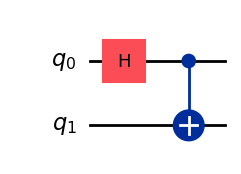

In [5]:
qc.draw('mpl')

#Setup six different observables here 

We have initiallyimported the above in order to map the lables into Observables function #from qiskit.quantum_info import SparsePauliOp

Below are the Gates Idenity, Pauli Z , Pauli X and their combinations
Operator notation for example zz in the below is the short form for tensor product of Z * Z, which means measuing Z on qubit 1 and Z on qubit 0 together, and obtain information about the correlation between qubit1 and qubit 0. Expectation values like this are also typically written as <Z1Z> (this is braket notation)  I is an Identiy matrix

In [6]:
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

Step2 . Optimize the circuits and operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions ) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise.
The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA (Instruction set Architecture)

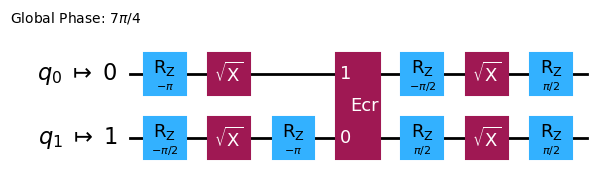

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
# here i have already saved my credentials by connecting to IBM's Run time Quantum via my API Key that can be found in (https://quantum.ibm.com/) after you have enrolled with your email id.
service =QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
# Convert to an ISA Circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw('mpl', idle_wires=False)

Step3. Execute using the quantum primitives
Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of observable by using the Estimator class. here there are two primitives one is Estimator and the other is a sampler, this can be used to get data from a quantum computer. These objects posses a run() method that executes the selection of circuits,observables, and parameters if applicable, using a primitive unified bloc

In [11]:
# Construct the Estimator instance
estimator = Estimator(mode = backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
mapped_observables = [ 
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
# one pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
# user the job ID to retrieve your job data later
print(f">>> JobID:{job.job_id()}")

>>> JobID:cwj0vxz40e000088zfzg


In [12]:
# This is the result of the entire submission. We have submitted one Pub (Primitive Unified Bloc)
# so this contains one inner result (and some metadata of its own)
job_result =job.result()
# This is the result from our single pub, which had six observables, 
# so contains information on all six.
pub_result = job.result()[0]

Step.4 Analyze the results
The analyze step is typicall where you migt postprocess your results using, for example measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. For this specific example plot each of the expectation values that were measured for our circuit.




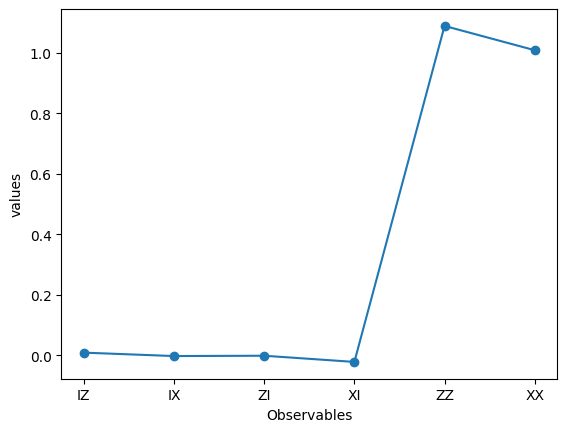

In [14]:
#Plot the result
from matplotlib import pyplot as plt
values = pub_result.data.evs
errors = pub_result.data.stds
#plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('values')
plt.show()